# CNN preentrenada: VGG19

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import tensorflow as tf

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.applications.resnet50 import ResNet50
from keras import backend as K

2024-05-10 16:17:24.434806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 16:17:24.434847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 16:17:24.435976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 16:17:25.897523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Cargar datos

Se va a realizar la carga, preprocesamiento y visualización de los datos con el objetivo de prepararlos para su uso en modelos de redes neuronales. A continuación, se detalla el flujo de trabajo implementado:

1. **Definición de rutas y carga de imágenes**: Se especifican las rutas de acceso a las carpetas que contienen las imágenes de entrenamiento y prueba para lesiones benignas y malignas. Las imágenes se cargan en memoria, convirtiéndolas al formato RGB para garantizar la consistencia en la representación de color.

2. **Generación de etiquetas**: Para cada imagen, se asigna una etiqueta numérica que indica si la lesión es benigna (0) o maligna (1). Este proceso se realiza tanto para el conjunto de entrenamiento como de prueba.

3. **Combinación y barajado de datos**: Los datos de imágenes y etiquetas se combinan y luego se barajan aleatoriamente. Este paso es crucial para evitar cualquier sesgo durante el entrenamiento del modelo, asegurando que la distribución de los ejemplos sea uniforme.

4. **Visualización de los datos**: Finalmente, se visualiza una selección de imágenes del conjunto de entrenamiento. Cada imagen se muestra con su respectiva etiqueta, permitiendo una verificación visual rápida de la correcta carga y etiquetado de los datos.


In [2]:
folder_benign_train = 'dataset/data/train/benign'
folder_malignant_train = 'dataset/data/train/malignant'

folder_benign_test = 'dataset/data/test/benign'
folder_malignant_test = 'dataset/data/test/malignant'

In [3]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [4]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [5]:
# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [6]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

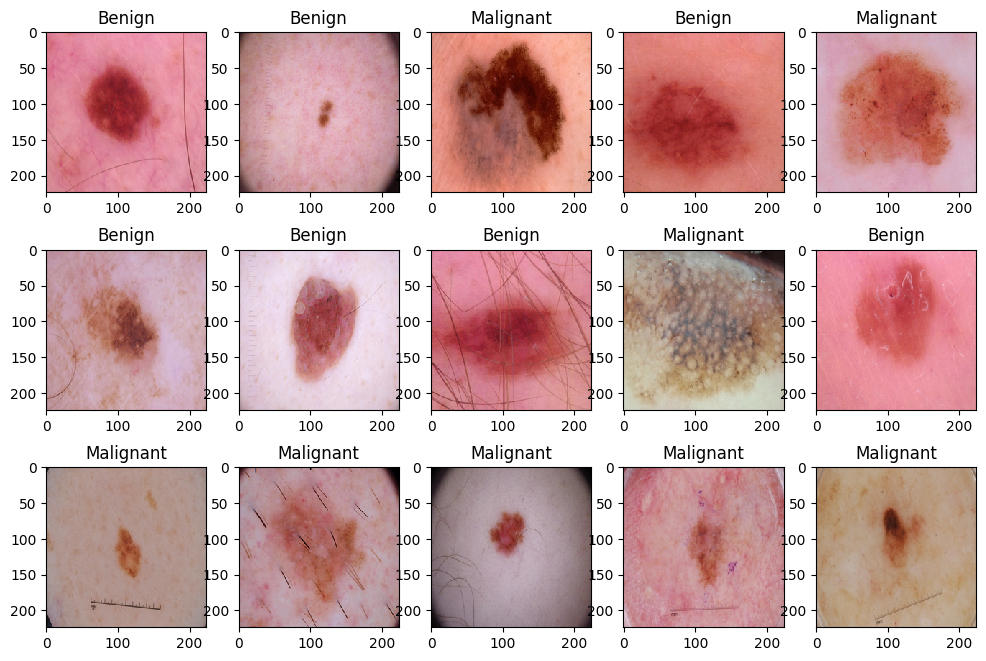

In [7]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Convertir etiquetas a categóricas

In [8]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalizar
Se realiza una normalización de los valores de píxeles de las imágenes tanto en el conjunto de entrenamiento como en el de prueba. Cada valor de píxel, originalmente en el rango de 0 a 255, se divide por 255 para obtener valores en el rango de 0 a 1. De esta manera se mejora la convergencia del modelo durante el entrenamiento, asegurando que todos los píxeles contribuyan equitativamente al aprendizaje y que los procesos computacionales se optimicen.

In [9]:
X_train = X_train/255.
X_test = X_test/255. 

# Cargar modelo preentrenado

In [11]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

2024-05-10 16:18:01.015881: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
conv_base.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at
all.

In [13]:
def extract_features(samples, labels):
    features = conv_base.predict(samples)
    return features, labels

X_train_features, y_train_features = extract_features(X_train, y_train)
X_test_features, y_test_features = extract_features(X_test, y_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step


In [14]:
train_features = np.reshape(X_train_features, (X_train_features.shape[0], 7 * 7 * 512))
test_features = np.reshape(X_test_features, (X_test_features.shape[0], 7 * 7 * 512))

In [22]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Usar 2 unidades de salida con activación softmax

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',  # Usar categorical_crossentropy para clasificación multiclase
              metrics=['accuracy'])

history = model.fit(train_features, y_train_features,
                    epochs=100,
                    batch_size=20,
                    validation_data=(test_features, y_test_features))

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6561 - loss: 0.6274 - val_accuracy: 0.7970 - val_loss: 0.4242
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7791 - loss: 0.4696 - val_accuracy: 0.8121 - val_loss: 0.3897
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8072 - loss: 0.4222 - val_accuracy: 0.7985 - val_loss: 0.4110
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8155 - loss: 0.4036 - val_accuracy: 0.8303 - val_loss: 0.3669
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8374 - loss: 0.3803 - val_accuracy: 0.8318 - val_loss: 0.3546
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8289 - loss: 0.3851 - val_accuracy: 0.8348 - val_loss: 0.3552
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8472 - loss: 0.3347 - val_accuracy: 0.8364 - val_loss: 0.3492
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8444 - loss: 0.3355 - 

In [23]:
# guardar modelo
if not os.path.exists('models'):
    print('No existe la carpeta')
    os.mkdir('models')

model.save('models/cnn_vgg19-100.h5')

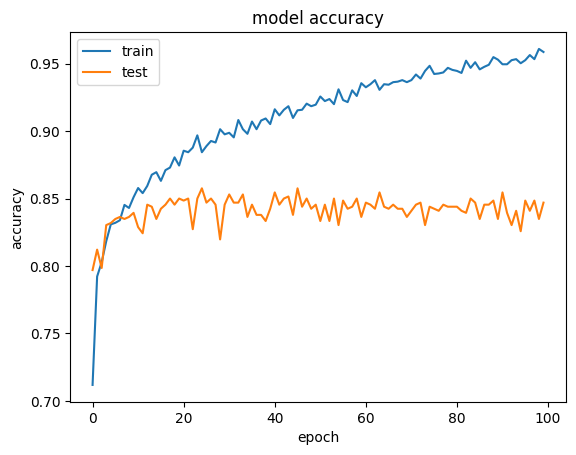

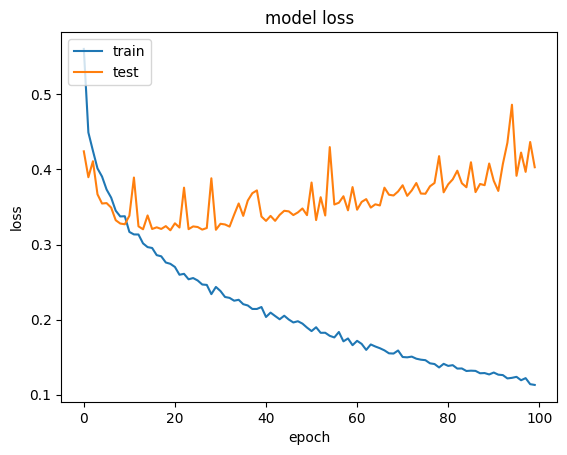

<Figure size 640x480 with 0 Axes>

In [24]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/acc-100.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/loss-100.png')

## Forma 2
Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model.
However, for this same reason, this technique is far more expensive than the first one.

In [33]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG19

# Cargar la base convolucional VGG19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [39]:
model = models.Sequential()
model.add(conv_base)  # Añade la base convolucional
model.add(layers.Flatten())  # Aplanar las características convolucionales
model.add(layers.Dense(256, activation='relu'))  # Añadir capas densas
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Usar 2 unidades de salida con activación softmax

In [40]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32


In [28]:
conv_base.trainable = False

In [29]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [41]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',  # Usar categorical_crossentropy para clasificación multiclase
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Ajusta este valor según el tamaño de tu conjunto de datos
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,  # Ajusta este valor según el tamaño de tu conjunto de datos
    verbose=2)

Epoch 1/30


In [ ]:
model.save('models/cnn_vgg19-2-30.h5')

In [ ]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/acc2-100.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/loss2-100.png')